In [3]:
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# -----------------------------
# Load JSONs into a DataFrame
# -----------------------------
def load_runs(base_dir, potential="linear"):
    pattern = os.path.join(base_dir, potential, "N*", "*", f"{potential}_*.json")
    rows = []
    for fp in glob.glob(pattern):
        with open(fp, "r") as f:
            d = json.load(f)

        N = int(d["N"])
        x_max = float(d["x_max"])
        cutoff = int(d["cutoff"])  # number of x-grid points per site (2**n_boson_qubits)

        eig = d.get("eigenvalues", [])
        E0 = float(min(eig)) if len(eig) else np.nan

        rows.append(
            dict(
                N=N,
                x_max=x_max,
                cutoff=cutoff,
                E0=E0,
                file=fp,
            )
        )

    df = pd.DataFrame(rows).sort_values(["N", "cutoff", "x_max"]).reset_index(drop=True)
    return df


def add_target_precision(df, E_target=0.0, eps=1e-16):
    df = df.copy()
    df["E_target"] = float(E_target)
    df["E_err"] = (df["E0"] - df["E_target"]).abs()
    df["precision"] = -np.log10(np.maximum(df["E_err"], eps))
    return df


# -----------------------------
# Plot: precision vs x_max
# -----------------------------
def plot_precision_vs_xmax(df, N, potential="linear", metric="precision"):
    sub = df[df["N"] == N].copy()
    if sub.empty:
        print(f"No data for N={N}")
        return

    plt.figure(figsize=(8, 5))
    for cutoff, g in sub.groupby("cutoff"):
        g = g.sort_values("x_max")
        plt.plot(g["x_max"], g[metric], marker="o", linewidth=2, label=f"cutoff={cutoff}")

    plt.xlabel(r"$x_{\max}$")
    plt.ylabel(metric)
    plt.title(f"{potential}: N={N} ({metric} vs $x_\\max$)")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
# -----------------------------
# Example usage
# -----------------------------
base_dir = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\Wess-Zumino\Analyses\x_max_sweep\HamiltonianDataPosition-XMax\dirichlet"   # <-- change this
potential = "linear"

df = load_runs(base_dir, potential=potential)
dfp = add_target_precision(df, E_target=0.0)


# 2) OR "within each cutoff curve, do I plateau as x_max increases?"
# dfp = add_reference_and_precision(df, ref_mode="best_per_N_and_cutoff")

# for N in sorted(dfp["N"].unique()):
#     plot_precision_vs_xmax(dfp, N=N, potential=potential, metric="precision")

# Optional: also plot the raw absolute error on a log scale
def plot_error_vs_xmax(dfp, N, potential="linear"):
    sub = dfp[dfp["N"] == N].copy()
    plt.figure(figsize=(8, 5))
    for cutoff, g in sub.groupby("cutoff"):
        g = g.sort_values("x_max")
        plt.semilogy(g["x_max"], g["E_err"], marker="o", linewidth=2, label=f"cutoff={cutoff}")
    plt.xlabel(r"$x_{\max}$")
    plt.ylabel(r"$|E_0 - E_{\rm ref}|$")
    plt.title(f"{potential}: N={N} (energy error vs $x_\\max$)")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()



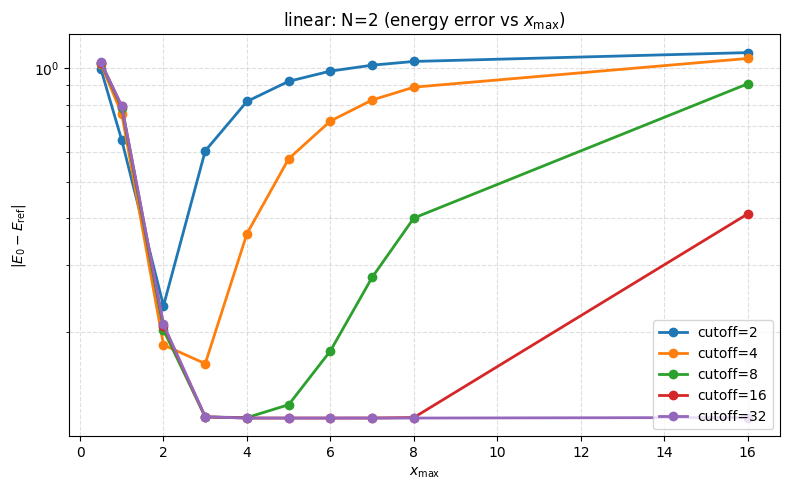

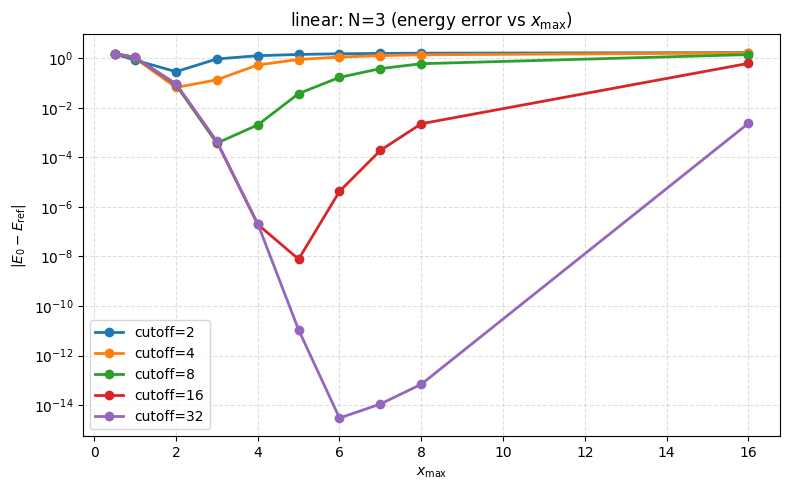

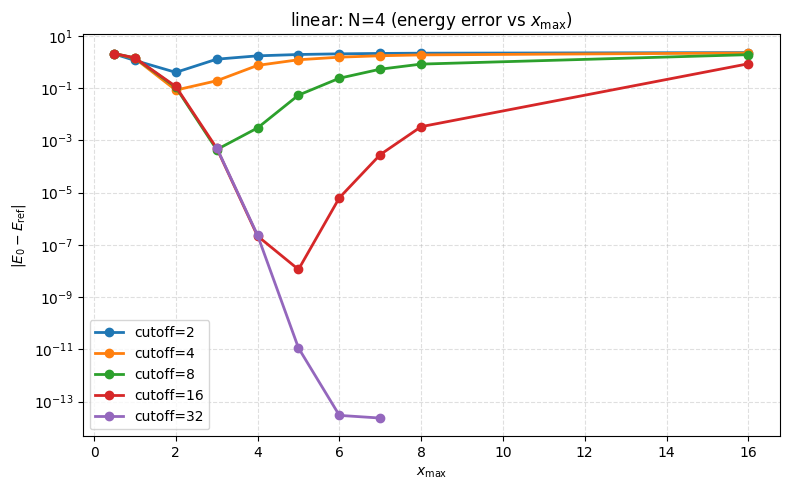

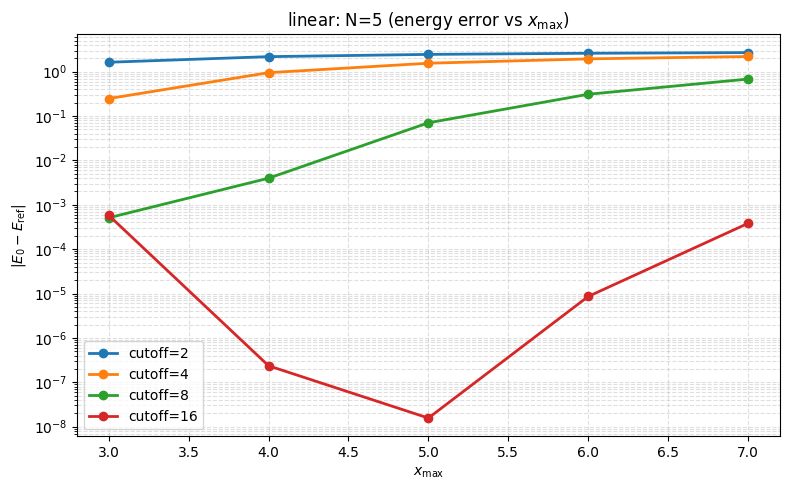

In [8]:
for N in sorted(dfp["N"].unique()):
    plot_error_vs_xmax(dfp, N=N, potential=potential)